In [1]:
import os.path as osp

import torch
import torch.nn.functional as F
from sklearn.metrics import roc_auc_score

from torch_geometric.utils import (negative_sampling, remove_self_loops,
                                   add_self_loops)
from torch_geometric.datasets import Planetoid
import torch_geometric.transforms as T
from torch_geometric.nn import GCNConv, ChebConv, GINConv, GATConv  # noqa
from torch_geometric.utils import train_test_split_edges
import argparse
import numpy as np
import random
import os
from sklearn.metrics import roc_auc_score, f1_score
import json
from torch.nn import Sequential, ReLU, Linear

torch.autograd.set_detect_anomaly(True)

class GradReverse(torch.autograd.Function):
    """
    Implement the gradient reversal layer for the convenience of domain adaptation neural network.
    The forward part is the identity function while the backward part is the negative function.
    """
    @staticmethod
    def forward(ctx, x):
        return x.view_as(x)

    @staticmethod
    def backward(ctx, grad_output):
        return grad_output.neg()

class GradientReversalLayer(torch.nn.Module):
    def __init__(self):
        super(GradientReversalLayer, self).__init__()

    def forward(self, inputs):
        return GradReverse.apply(inputs)

In [2]:
def sim(lambda_reg):
    class Net(torch.nn.Module):
        def __init__(self, name='GCNConv'):
            super(Net, self).__init__()
            self.name = name
            if (name == 'GCNConv'):
                self.conv1 = GCNConv(dataset.num_features, 64)
                self.conv2 = GCNConv(64, 64)
                self.conv3 = GCNConv(64, 64)
            elif (name == 'ChebConv'):
                self.conv1 = ChebConv(dataset.num_features, 64, K=2)
                self.conv2 = ChebConv(64, 64, K=2)
                self.conv3 = ChebConv(64, 64, K=2)
            elif (name == 'GATConv'):
                self.conv1 = GATConv(dataset.num_features, 64)
                self.conv2 = GATConv(64, 64)
                self.conv3 = GATConv(64, 64)

            self.attr = GCNConv(64, dataset.num_classes, cached=True,
                                    normalize=not gdc)

            self.attack = GCNConv(64, dataset.num_classes, cached=True,
                                normalize=not gdc)
            self.reverse = GradientReversalLayer()

        def forward(self, pos_edge_index, neg_edge_index):

            if (self.name == 'GINConv'):
                x = F.relu(self.conv1(data.x, data.train_pos_edge_index))
                x = self.bn1(x)
                x = F.relu(self.conv2(x, data.train_pos_edge_index))
                x = self.bn2(x)
                x = F.relu(self.conv3(x, data.train_pos_edge_index))
                x = self.bn3(x)
            else:
                x = F.relu(self.conv1(data.x, data.train_pos_edge_index))
                x = self.conv2(x, data.train_pos_edge_index)
                x = self.conv3(x, data.train_pos_edge_index)

            feat = x
            attr = self.attr(x, edge_index, edge_weight)

            #print(feat.size())
            attack = self.reverse(x)
            att = self.attack(attack, edge_index, edge_weight)

            total_edge_index = torch.cat([pos_edge_index, neg_edge_index], dim=-1)
            x_j = torch.index_select(x, 0, total_edge_index[0])
            x_i = torch.index_select(x, 0, total_edge_index[1])

            """
            print(x_j.size())
            print(x_i.size())
            """

            res = torch.einsum("ef,ef->e", x_i, x_j)

            #print(res.size())
            return res, F.log_softmax(attr, dim=1), att, feat
    
    m = 'GCNConv' 
    seed = 42
    lr = 0.01
    num_epochs = 300
    finetune_epochs = 100
    torch.manual_seed(seed)
    torch.cuda.manual_seed_all(seed)
    np.random.seed(seed)
    random.seed(seed)
    torch.backends.cudnn.deterministic = True
    torch.backends.cudnn.benchmark = False
    os.environ['PYTHONHASHSEED'] = str(seed)

    dataset = "Cora"
    path = osp.join('..', 'data', dataset)
    dataset = Planetoid(path, dataset, 'public', T.NormalizeFeatures())
    data = dataset[0]
    gdc = False
    #if gdc:
    #    gdc = T.GDC(self_loop_weight=1, normalization_in='sym',
    #                normalization_out='col',
    #                diffusion_kwargs=dict(method='ppr', alpha=0.05),
    #                sparsification_kwargs=dict(method='topk', k=128,
    #                                        dim=0), exact=True)
    #    data = gdc(data)

    labels = data.y.cuda()
    edge_index, edge_weight = data.edge_index.cuda(), data.edge_attr

    print(labels.size())
    # Train/validation/test
    data = train_test_split_edges(data)

    print(labels)

    device = torch.device('cuda')
    model, data = Net(m).cuda(), data.to("cuda")

    #if (m=='GINConv'):
    #    optimizer = torch.optim.Adam([
    #        dict(params=model.conv1.parameters(), weight_decay=0),
    #        dict(params=model.bn1.parameters(), weight_decay=0),
    #        dict(params=model.conv2.parameters(), weight_decay=0),
    #        dict(params=model.bn2.parameters(), weight_decay=0),
    #    ], lr=lr)
    #else:
    optimizer = torch.optim.Adam([
        dict(params=model.conv1.parameters(), weight_decay=0),
        dict(params=model.conv2.parameters(), weight_decay=0),
        dict(params=model.conv3.parameters(), weight_decay=0),
        dict(params=model.attr.parameters(), weight_decay=0)
    ], lr=lr)

    #if (m=='GINConv'):
    #    optimizer_att = torch.optim.Adam([
    #        dict(params=model.conv2.parameters(), weight_decay=5e-4), 
    #        dict(params=model.bn2.parameters(), weight_decay=0),  
    #        dict(params=model.attack.parameters(), weight_decay=5e-4),
    #    ], lr=lr * lambda_reg)
    #else:
    optimizer_att = torch.optim.Adam([
        dict(params=model.conv1.parameters(), weight_decay=5e-4),
        dict(params=model.conv2.parameters(), weight_decay=5e-4),   
        dict(params=model.conv3.parameters(), weight_decay=5e-4),   
        dict(params=model.attack.parameters(), weight_decay=5e-4),
    ], lr=lr * lambda_reg)

    def get_link_labels(pos_edge_index, neg_edge_index):
        link_labels = torch.zeros(pos_edge_index.size(1) +
                                neg_edge_index.size(1)).float().to(device)
        link_labels[:pos_edge_index.size(1)] = 1.
        return link_labels

    global switch
    switch = True
    
    def train():
        global switch
        model.train()

        x, pos_edge_index = data.x, data.train_pos_edge_index

        _edge_index, _ = remove_self_loops(pos_edge_index)
        pos_edge_index_with_self_loops, _ = add_self_loops(_edge_index,
                                                        num_nodes=x.size(0))

        neg_edge_index = negative_sampling(
            edge_index=pos_edge_index_with_self_loops, num_nodes=x.size(0),
            num_neg_samples=pos_edge_index.size(1))

        link_logits, attr_prediction, attack_prediction,_ = model(pos_edge_index, neg_edge_index)
        link_labels = get_link_labels(pos_edge_index, neg_edge_index)

        loss = F.binary_cross_entropy_with_logits(link_logits, link_labels)
        one_hot = torch.cuda.FloatTensor(attack_prediction.size(0), attack_prediction.size(1)).zero_()
        mask = one_hot.scatter_(1, labels.view(-1,1), 1)
    
        nonzero = mask * attack_prediction
        avg = torch.mean(nonzero, dim = 0)
        loss2 = torch.abs(torch.max(avg) - torch.min(avg))
        
        if switch:
            optimizer.zero_grad()
            loss.backward()
            optimizer.step()
            switch = False
        else:
            optimizer_att.zero_grad()
            loss2.backward()
            optimizer_att.step()
            switch = True
            
            for p in model.conv1.parameters():
                p.data.clamp_(-1, 1)
            for p in model.conv2.parameters():
                p.data.clamp_(-1, 1)
            for p in model.conv3.parameters():
                p.data.clamp_(-1, 1)
            for p in model.attack.parameters():
                p.data.clamp_(-1, 1)

        return loss


    def test():
        model.eval()
        perfs = []
        for prefix in ["val", "test"]:
            pos_edge_index, neg_edge_index = [
                index for _, index in data("{}_pos_edge_index".format(prefix),
                                        "{}_neg_edge_index".format(prefix))
            ]
            link_probs = torch.sigmoid(model(pos_edge_index, neg_edge_index)[0])
            link_labels = get_link_labels(pos_edge_index, neg_edge_index)
            link_probs = link_probs.detach().cpu().numpy()
            link_labels = link_labels.detach().cpu().numpy()
            perfs.append(roc_auc_score(link_labels, link_probs))
        return perfs


    best_val_perf = test_perf = 0
    for epoch in range(1, num_epochs+1):
        train_loss = train()
        val_perf, tmp_test_perf = test()
        if val_perf > best_val_perf:
            best_val_perf = val_perf
            test_perf = tmp_test_perf
        log = 'Epoch: {:03d}, Loss: {:.4f}, Val: {:.4f}, Test: {:.4f}'
        #print(log.format(epoch, train_loss, val_perf, tmp_test_perf))


    optimizer_attr = torch.optim.Adam([
        dict(params=model.attr.parameters(), weight_decay=5e-4),
    ], lr=lr)

    def train_attr():
        model.train()
        optimizer_attr.zero_grad()

        x, pos_edge_index = data.x, data.train_pos_edge_index

        _edge_index, _ = remove_self_loops(pos_edge_index)
        pos_edge_index_with_self_loops, _ = add_self_loops(_edge_index,
                                                        num_nodes=x.size(0))

        neg_edge_index = negative_sampling(
            edge_index=pos_edge_index_with_self_loops, num_nodes=x.size(0),
            num_neg_samples=pos_edge_index.size(1))

        F.nll_loss(model(pos_edge_index, neg_edge_index)[1][data.train_mask], labels[data.train_mask]).backward()
        optimizer_attr.step()


    @torch.no_grad()
    def test_attr():
        model.eval()
        accs = []
        m = ['train_mask', 'val_mask', 'test_mask']
        i = 0
        for _, mask in data('train_mask', 'val_mask', 'test_mask'):

            if (m[i] == 'train_mask') :
                x, pos_edge_index = data.x, data.train_pos_edge_index

                _edge_index, _ = remove_self_loops(pos_edge_index)
                pos_edge_index_with_self_loops, _ = add_self_loops(_edge_index,
                                                                num_nodes=x.size(0))

                neg_edge_index = negative_sampling(
                    edge_index=pos_edge_index_with_self_loops, num_nodes=x.size(0),
                    num_neg_samples=pos_edge_index.size(1))
            else:
                pos_edge_index, neg_edge_index = [
                index for _, index in data("{}_pos_edge_index".format(m[i].split("_")[0]),
                                        "{}_neg_edge_index".format(m[i].split("_")[0]))
                ]
            _, logits, _, _ = model(pos_edge_index, neg_edge_index)

            pred = logits[mask].max(1)[1]
            #acc = pred.eq(data.y[mask]).sum().item() / mask.sum().item()
            #accs.append(acc)

            macro = f1_score((data.y[mask]).cpu().numpy(), pred.cpu().numpy(),average='macro')
            accs.append(macro)

            i+=1
        return accs

    if True:
        best_val_acc = test_acc = 0
        for epoch in range(1, finetune_epochs+1):
            train_attr()
            train_acc, val_acc, tmp_test_acc = test_attr()
            if val_acc > best_val_acc:
                best_val_acc = val_acc
                test_acc = tmp_test_acc
            log = 'Epoch: {:03d}, Train: {:.4f}, Val: {:.4f}, Test: {:.4f}'
            print(log.format(epoch, train_acc, val_acc, tmp_test_acc))
    return model#, test_acc

In [23]:
L1 = 0.75
L0 = 0

model_1 = sim(L1)
print("=====================")
model_0 = sim(L0)

torch.Size([2708])
tensor([3, 4, 4,  ..., 3, 3, 3], device='cuda:0')
Epoch: 001, Train: 0.1649, Val: 0.1767, Test: 0.1679
Epoch: 002, Train: 0.1880, Val: 0.2409, Test: 0.2131
Epoch: 003, Train: 0.2265, Val: 0.3265, Test: 0.2967
Epoch: 004, Train: 0.3028, Val: 0.3619, Test: 0.3430
Epoch: 005, Train: 0.3040, Val: 0.4055, Test: 0.3796
Epoch: 006, Train: 0.3361, Val: 0.4095, Test: 0.3939
Epoch: 007, Train: 0.3675, Val: 0.4174, Test: 0.3983
Epoch: 008, Train: 0.3970, Val: 0.4192, Test: 0.3976
Epoch: 009, Train: 0.4301, Val: 0.4195, Test: 0.4007
Epoch: 010, Train: 0.4189, Val: 0.4159, Test: 0.4035
Epoch: 011, Train: 0.4316, Val: 0.4159, Test: 0.4056
Epoch: 012, Train: 0.4369, Val: 0.4091, Test: 0.4120
Epoch: 013, Train: 0.4566, Val: 0.4143, Test: 0.4226
Epoch: 014, Train: 0.4640, Val: 0.4316, Test: 0.4350
Epoch: 015, Train: 0.4635, Val: 0.4318, Test: 0.4564
Epoch: 016, Train: 0.4748, Val: 0.4554, Test: 0.4748
Epoch: 017, Train: 0.4933, Val: 0.4922, Test: 0.4951
Epoch: 018, Train: 0.5284, Val

Epoch: 055, Train: 0.8294, Val: 0.6720, Test: 0.7066
Epoch: 056, Train: 0.8294, Val: 0.6720, Test: 0.7059
Epoch: 057, Train: 0.8294, Val: 0.6720, Test: 0.7072
Epoch: 058, Train: 0.8294, Val: 0.6720, Test: 0.7065
Epoch: 059, Train: 0.8364, Val: 0.6720, Test: 0.7066
Epoch: 060, Train: 0.8369, Val: 0.6720, Test: 0.7066
Epoch: 061, Train: 0.8436, Val: 0.6695, Test: 0.7073
Epoch: 062, Train: 0.8436, Val: 0.6710, Test: 0.7088
Epoch: 063, Train: 0.8436, Val: 0.6710, Test: 0.7088
Epoch: 064, Train: 0.8436, Val: 0.6710, Test: 0.7088
Epoch: 065, Train: 0.8436, Val: 0.6723, Test: 0.7088
Epoch: 066, Train: 0.8436, Val: 0.6706, Test: 0.7095
Epoch: 067, Train: 0.8436, Val: 0.6706, Test: 0.7095
Epoch: 068, Train: 0.8436, Val: 0.6705, Test: 0.7095
Epoch: 069, Train: 0.8436, Val: 0.6705, Test: 0.7087
Epoch: 070, Train: 0.8506, Val: 0.6705, Test: 0.7087
Epoch: 071, Train: 0.8506, Val: 0.6719, Test: 0.7073
Epoch: 072, Train: 0.8506, Val: 0.6719, Test: 0.7104
Epoch: 073, Train: 0.8506, Val: 0.6719, Test: 

In [24]:
def feat(model):
    model.train()
    
    dataset = "Cora"
    path = osp.join('..', 'data', dataset)
    dataset = Planetoid(path, dataset, 'public', T.NormalizeFeatures())
    data = dataset[0]
    gdc = False
    if gdc:
        gdc = T.GDC(self_loop_weight=1, normalization_in='sym',
                    normalization_out='col',
                    diffusion_kwargs=dict(method='ppr', alpha=0.05),
                    sparsification_kwargs=dict(method='topk', k=128,
                                            dim=0), exact=True)
        data = gdc(data)

    labels = data.y.cuda()
    edge_index, edge_weight = data.edge_index.cuda(), data.edge_attr

    print(labels.size())
    # Train/validation/test
    data = train_test_split_edges(data)
    
    x, pos_edge_index = data.x, data.train_pos_edge_index

    _edge_index, _ = remove_self_loops(pos_edge_index)
    pos_edge_index_with_self_loops, _ = add_self_loops(_edge_index,
                                                    num_nodes=x.size(0))

    neg_edge_index = negative_sampling(
        edge_index=pos_edge_index_with_self_loops, num_nodes=x.size(0),
        num_neg_samples=pos_edge_index.size(1))

    return model(pos_edge_index.cuda(), neg_edge_index.cuda())[-1]

In [25]:
feat0 = feat(model_0)
#feat1 = feat(model_1)
feat1 = feat(model_1)

torch.Size([2708])
torch.Size([2708])


In [26]:
dataset = "Cora"
path = osp.join('..', 'data', dataset)
dataset = Planetoid(path, dataset, 'public', T.NormalizeFeatures())
data = dataset[0]
labels = data.y.detach().cpu().numpy()

In [27]:
from sklearn.manifold import TSNE
tsne = TSNE(n_components=2, verbose=1, perplexity=120, n_iter=1500)
tsne_0 = tsne.fit_transform(feat0.cpu().detach().numpy())
#tsne_1 = tsne.fit_transform(feat1.cpu().detach().numpy())
tsne_1 = tsne.fit_transform(feat1.cpu().detach().numpy())

[t-SNE] Computing 361 nearest neighbors...
[t-SNE] Indexed 2708 samples in 0.001s...
[t-SNE] Computed neighbors for 2708 samples in 0.347s...
[t-SNE] Computed conditional probabilities for sample 1000 / 2708
[t-SNE] Computed conditional probabilities for sample 2000 / 2708
[t-SNE] Computed conditional probabilities for sample 2708 / 2708
[t-SNE] Mean sigma: 0.575085
[t-SNE] KL divergence after 250 iterations with early exaggeration: 62.829163
[t-SNE] KL divergence after 1500 iterations: 0.671730
[t-SNE] Computing 361 nearest neighbors...
[t-SNE] Indexed 2708 samples in 0.000s...
[t-SNE] Computed neighbors for 2708 samples in 0.336s...
[t-SNE] Computed conditional probabilities for sample 1000 / 2708
[t-SNE] Computed conditional probabilities for sample 2000 / 2708
[t-SNE] Computed conditional probabilities for sample 2708 / 2708
[t-SNE] Mean sigma: 0.383118
[t-SNE] KL divergence after 250 iterations with early exaggeration: 56.288761
[t-SNE] KL divergence after 1500 iterations: 0.58114

import seaborn as sns
sns.set_style("whitegrid", {'axes.grid' : False})
sns.set_style("dark")
sns.set(rc={'figure.figsize':(8,8)})
palette = sns.color_palette("bright", 7)
ax = sns.scatterplot(tsne_results[:,0], tsne_results[:,1], hue=lab.detach().cpu().numpy(), legend='full', palette=palette)
ax.grid(False)
ax.patch.set_facecolor('white')
ax.set_axis_off()

In [28]:
data

Data(edge_index=[2, 10556], test_mask=[2708], train_mask=[2708], val_mask=[2708], x=[2708, 1433], y=[2708])

In [29]:
import networkx as nx
import seaborn as sns
import matplotlib.pyplot as plt
dataset = "Cora"
path = osp.join('..', 'data', dataset)
dataset = Planetoid(path, dataset)
data = dataset[0]
el = data.edge_index.cpu().numpy()
G = nx.Graph([(el[0,i],el[1,i]) for i in range(el.shape[1])])

In [30]:
pos0 = {}
for i in range(2708):
    pos0[i]=[tsne_0[i,0],tsne_0[i,1]]
    
pos135 = {}
for i in range(2708):
    pos135[i]=[tsne_1[i,0],tsne_1[i,1]]

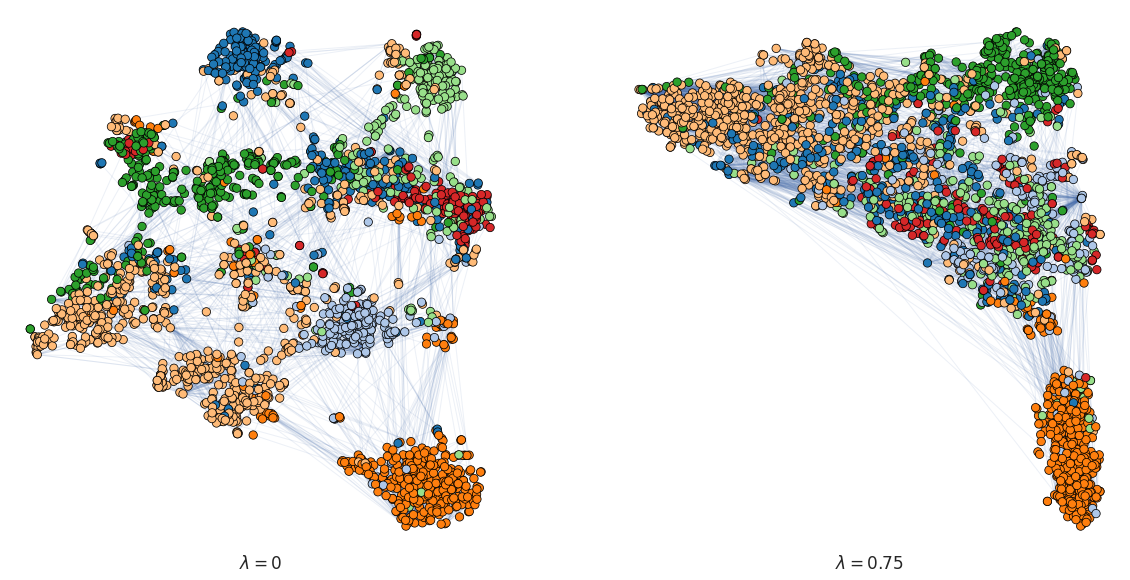

In [32]:
sns.set(rc={'figure.figsize':(20,10)})

fig, axs = plt.subplots(ncols=2)

palette = sns.color_palette("tab20",7)
nx.draw_networkx_edges(G, pos0, alpha=0.1,edge_color='b',style='solid',ax=axs[0])
sns.scatterplot(tsne_0[:,0], tsne_0[:,1], hue=labels, legend=None, palette=palette,ax=axs[0],s=70, edgecolor="black")

axs[0].grid(False)
axs[0].patch.set_facecolor('white')
axs[0].set(xticks=[],yticks=[])
axs[0].set_xlabel(r'$\lambda = 0$', fontsize=17)

nx.draw_networkx_edges(G, pos135, alpha=0.1,edge_color='b',style='solid',ax=axs[1])
sns.scatterplot(tsne_1[:,0], tsne_1[:,1], hue=labels, legend=None, palette=palette,ax=axs[1],s=70, edgecolor="black")

axs[1].grid(False)
axs[1].patch.set_facecolor('white')
axs[1].set(xticks=[],yticks=[])
axs[1].set_xlabel(r'$\lambda = 0.75$', fontsize=17)

plt.show()

fig.savefig('cora.pdf', bbox_inches='tight') 

In [22]:
data.edge_index

tensor([[   0,    0,    0,  ..., 2707, 2707, 2707],
        [ 633, 1862, 2582,  ...,  598, 1473, 2706]])